In [1]:
import sys
sys.path.append("..")

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from ipywidgets import interact

# from conc_obj import EEGData
from classes.eeg_data import EEGData
from utils.plt import plot_psd, plot_montage
from utils.ica import plot_ica_comp

# MNE imports
import mne
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
# from csp.CSPObj import CSP

from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import json


***Macros***

>General use macros, importing JSON files to use as the configuration files

In [2]:
script_path = Path().resolve()
main_folder = (script_path / "../").resolve()
proj_folder = (script_path / "../../").resolve()

JSON_MAIN_PATH = main_folder / "config/config_main.json"
JSON_CSP_PATH = main_folder / "config/config_csp.json"
JSON_GRID_PATH = main_folder / "config/config_grid.json"
EVENTS_PATH = main_folder / "config/events.json"

with open(JSON_MAIN_PATH, "r") as f:
    config_main = json.load(f)

with open(JSON_CSP_PATH, "r") as f:
    config_csp = json.load(f)
    
with open(JSON_GRID_PATH, "r") as f:
    json_grid = json.load(f)

VERBOSE = config_main['verbose'].lower() == 'true'

L_FREQ = config_main['l_freq']
H_FREQ = config_main['h_freq']

N_SUBJECTS = config_main["n_subjects"]
N_COMPONENTS_ICA = config_main["n_components_ica"]
N_COMPONENTS_CSP = config_csp["n_components"]
N_COMPONENTS_PCA = N_COMPONENTS_CSP

"""
T0 corresponds to rest
T1 corresponds to onset of motion (real or imagined) of
the left fist (in runs 3, 4, 7, 8, 11, and 12)
both fists (in runs 5, 6, 9, 10, 13, and 14)
T2 corresponds to onset of motion (real or imagined) of
the right fist (in runs 3, 4, 7, 8, 11, and 12)
both feet (in runs 5, 6, 9, 10, 13, and 14)
"""


'\nT0 corresponds to rest\nT1 corresponds to onset of motion (real or imagined) of\nthe left fist (in runs 3, 4, 7, 8, 11, and 12)\nboth fists (in runs 5, 6, 9, 10, 13, and 14)\nT2 corresponds to onset of motion (real or imagined) of\nthe right fist (in runs 3, 4, 7, 8, 11, and 12)\nboth feet (in runs 5, 6, 9, 10, 13, and 14)\n'

In [3]:
mne.set_log_level("CRITICAL")

***Initialization of EEG object***

>***(If the files are not locally stored, it will download them to the user system automatically)***

>***Use of functions like .filter_data() also is obligatory if there is no data stored locally***

In [4]:
eeg_obj = EEGData(config_main, config_csp, proj_folder, verbose=VERBOSE)

#* Filters data and plots PSD to see differences
# eeg_obj.filter_data()

# eeg_obj.plot_psd_ba_filt(config_csp["freq_exec_hands_01"])

# eeg_obj.plot_psd(verbose=VERBOSE)


***Prediction - Loading testing data & ML models***

>***If we don't want to train our model and want to make predictions or see any metric right away, we can load the data and call the methods right away.***

>***Take into account that in order to change the events or any other parameter in the tools/methods loaded, you will have to train and save the entire model/data again!***

In [5]:

# X_test, y_test = eeg_obj.load_models()
# eeg_obj.pred(X_test, y_test)

**Basic information and montage plotting in 2D & 3D**
> ***The channel names can also be printed***

In [6]:

#* Plots different montages in 2D & 3D
# data = eeg_obj.get_raw_h()
# ch_names = data.info["ch_names"] 
# plot_montage(eeg_obj.montage, ch_names)

**ICA(Independent Component Analysys)**
> ***The number of components that ICA will try to sort out can be changed, it is advised to use values in the range [15-45]***

> ***Ocular artifacts are also removed, since they don't contribute to the muscular movement on this evaluation***

> ***The components can also be plotted and ocular artifacts, EOG, will be clearly visible***

/Users/Shared/42/total_persceptive_vortex/data/ica/sample_mmi_h_ica.fif


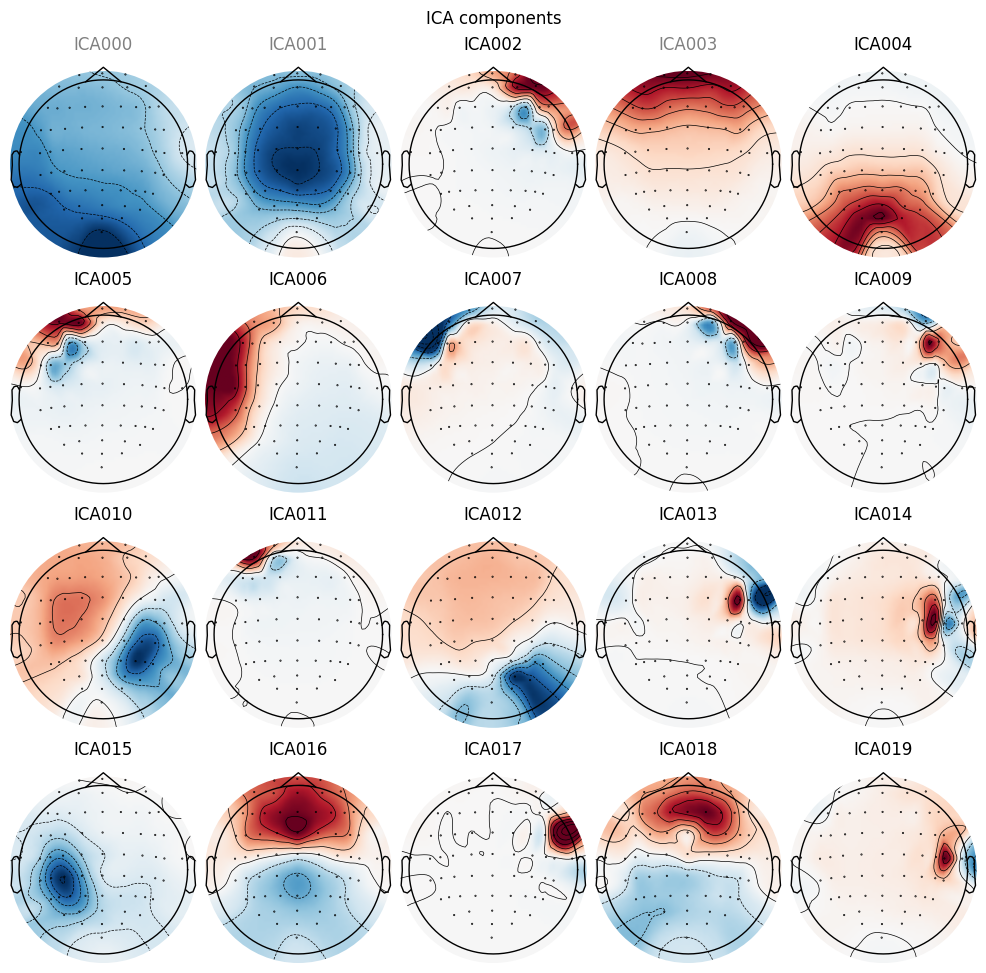

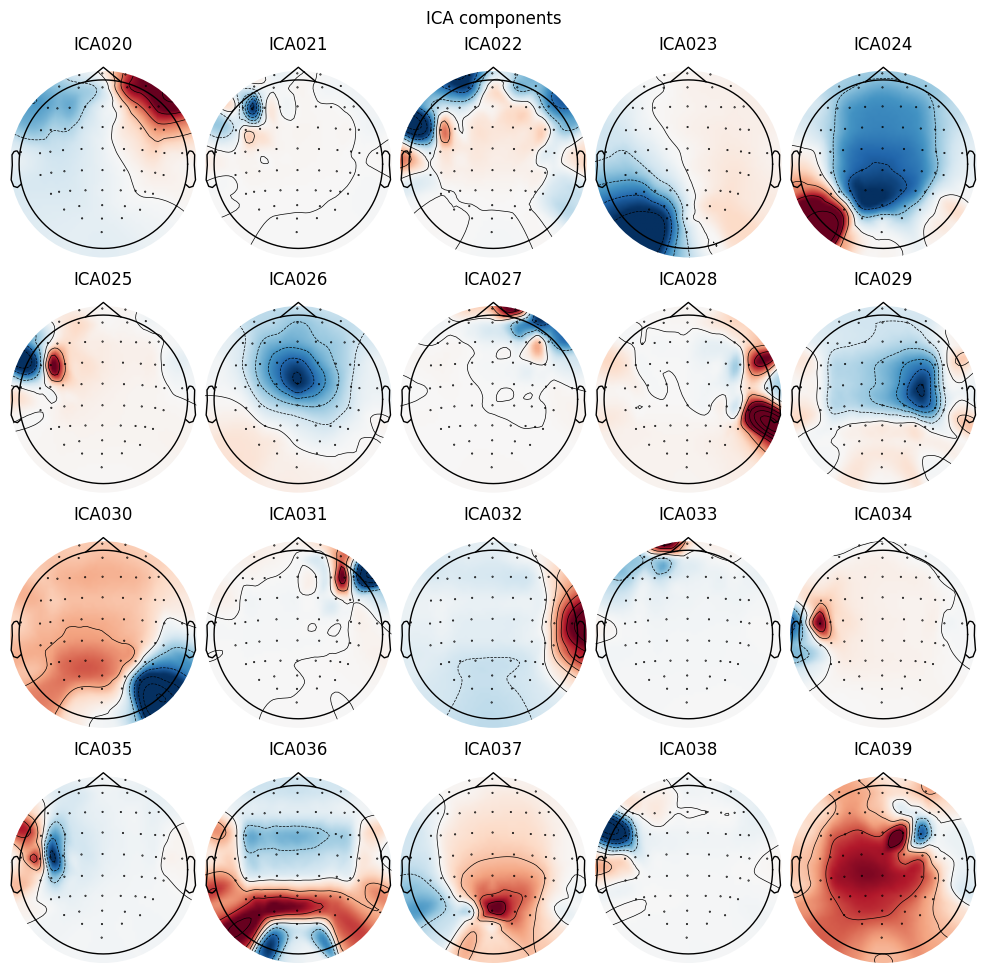

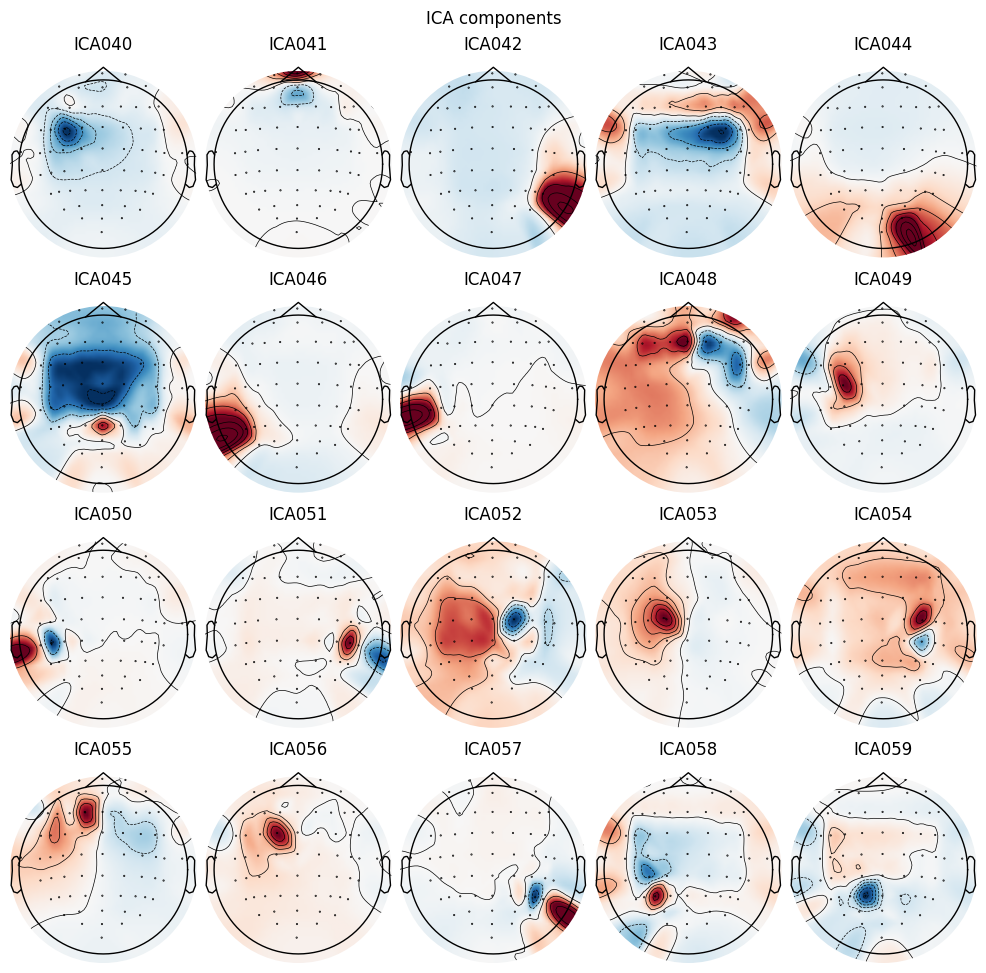

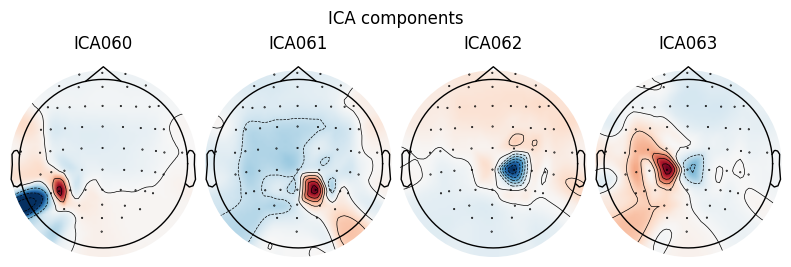

In [7]:

#* Computes ICA components
# eeg_obj.decomp_ica(n_components=N_COMPONENTS_ICA, plt_show=True, verbose=VERBOSE)

#* Plot components of ICA
plot_ica_comp(proj_folder / config_main["path_ica_h"])

**Specify events & create Epochs**
> ***The events used along with the JSON configuration will be crucial for the ML algorimths to work properly***


In [8]:
data, _ = eeg_obj.get_clean()
events, _ = eeg_obj.get_events()

event_l = config_csp["ev_blist_one"]
groupeve_dict = config_csp["event_dict_h"]

event_dict1 = {key: value for key, value in groupeve_dict.items() if value in event_l[0]}
print("Event dict. :", event_dict1)

print()
epochs = mne.Epochs(data, events, event_id=event_dict1, tmin=config_csp["tmin"], tmax=config_csp["tmax"], baseline=None, verbose=VERBOSE)
data = epochs.get_data()
labels = epochs.events[:, -1]

#* Divide the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Event dict. : {'do/left_hand': 1, 'do/right_hand': 2}

X_train shape: (720, 64, 641)
X_test shape: (180, 64, 641)


***Pipeline***

>The dimensionality reduction tools, classifications algorimths and signal processing (CSP) are included.

>The default values/functions have been proved to be good over tests.

In [26]:
svm_clf = SVC(kernel='rbf', C=350, gamma=0.025, probability=True)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)
rf_clf = RandomForestClassifier(n_estimators=150, max_depth=25, min_samples_split=15, random_state=42)
ensemble = VotingClassifier(estimators=[('svm', svm_clf), ('mlp', mlp_clf)], voting='soft')

# Create a new pipeline for LDA
pipeline = Pipeline([
    ('csp', CSP(n_components=12, reg='ledoit_wolf', log=True, norm_trace=False)),

    ('pca', PCA()),

    #* Choose only one of the following classifiers
	# ('clf', ensemble)
	# ('lda', LDA())
    ('svm', svm_clf)
	# ('rf', rf_clf)
    # ('mlp', mlp_clf)
])

# Fit the pipeline to the data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('csp', CSP(log=True, n_components=12, reg='ledoit_wolf')),
                ('pca', PCA()),
                ('svm', SVC(C=350, gamma=0.025, probability=True))])

***GridSearch - Parameter selection***

>Exhaustive search over specified parameter values for an estimator.

>The default values have been tested. Performance varies from event type selection.

In [27]:
from utils.grid_search import grid_finder, grid_search

grid, pipepline_grid = grid_finder(json_grid, 'svm', 'default')
print(grid)

grid_search(X_train, y_train, pipeline, grid)
# default -> {'rf__max_depth': 25, 'rf__min_samples_split': 10, 'rf__n_estimators': 50}
# wide -> {'rf__max_depth': 50, 'rf__min_samples_split': 50, 'rf__n_estimators': 400}

{'svm__C': [75, 100, 125], 'svm__gamma': [0.5, 1]}
Best parameters: {'svm__C': 125, 'svm__gamma': 0.5}
Best accuracy: 0.5610304685863099


***K-Fold Training/Testing***

>Split the data to train over different data sets, improves generalization.

>Remove the last step of the pipeline to get the proccesed data without the ML CLF algorimth

In [22]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Transform the data using the pipeline
# Create a new pipeline excluding the last step
pipeline_without_last_step = Pipeline(pipeline.steps[:-1])

# Transform the data using the new pipeline
processed_X_train = pipeline_without_last_step.transform(X_train)
processed_X_test = pipeline_without_last_step.transform(X_test)
print(processed_X_train.shape)


(720, 32)


***Cross Validation - The good ol' tester***

>We feed it the n_splits we chose on the K-folds along with the pipeline.

>It ensures that the training/testing datasets are not mixed & calculates the average score over the K-folds.

In [23]:
# Perform cross-validation
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)
scores = cross_val_score(pipeline, X_train, y_train, cv=cv)

print("Train set accuracy:", train_score)
print("Test set accuracy:", test_score)
print("<------------------------->")
print("Cross-validation scores:", scores)
print("Mean: ", np.mean(scores))

Train set accuracy: 0.9402777777777778
Test set accuracy: 0.6777777777777778
<------------------------->
Cross-validation scores: [0.53472222 0.5625     0.63194444 0.59722222 0.55555556]
Mean:  0.576388888888889


In [13]:

eeg_obj.train_model(processed_X_train, y_train)

eeg_obj.pred(processed_X_test, y_test, n_preds=30)

SVC(C=200, gamma=0.1)
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
Train Accuracy LDA: 0.7458333333333333
Train Accuracy SVM: 1.0
Train Accuracy RF: 1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
Train Accuracy RF: 1.0
Train Accuracy MLP: 1.0

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
epoch nb: [prediction] [truth] equal?
epoch 000:	[2]		[1]  False
epoch 001:	[2]		[2]  True
epoch 002:	[2]		[1]  False
epoch 003:	[2]		[2]  True
epoch 004:	[2]		[1]  False
epoch 005:	[2]		[1]  False
epoch 006:	[2]		[1]  False
epoch 007:	[2]		[2]  True
epoch 008:	[2]		[2]  True
epoch 009:	[2]		[2]  True
epoch 010:	[2]		[1]  False
epoch 011:	[2]		[1]  False
epoch 0

/Users/Shared/42/total_persceptive_vortex/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/Shared/42/total_persceptive_vortex/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


**Saving data locally**
> ***Saving and loading data locally saves time and computational power***

> ***Note that it is also needed to change the configuration at the JSON files to import local files***

In [14]:
#* Saves filtered and concatenated data for faster loading
# eeg_obj.save_type_data(type="raw")
# eeg_obj.save_type_data(type="filtered")
# eeg_obj.save_type_data(type="norm")
# eeg_obj.save_type_data(type="ica")
# eeg_obj.save_models()